In [6]:
import networkx as nx
from networkx.algorithms import approximation, community
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.lines import Line2D

matplotlib.rc('xtick', labelsize=13)     
matplotlib.rc('ytick', labelsize=13)
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
MAX_RECURSION_DEPTH = 10

def classical_MIS_approach(G, chosen_vertices=None, progress=None, verbose=0):
    chosen_vertices = chosen_vertices or set()
    progress = progress or [0]
    
    leftover_vertices = set(G)
    for i in chosen_vertices:
        leftover_vertices -= {i}
        leftover_vertices -= set(G.neighbors(i))
    # now, leftover_vertices contains the vertices in G that could still be added to the MIS
    
    if len(leftover_vertices) <= 1:
        chosen_vertices |= leftover_vertices
        assert_is_independent_set(G, chosen_vertices)
        progress.append(len(chosen_vertices))
        final_progress = progress[-1]
        progress = progress + [final_progress] * (MAX_RECURSION_DEPTH - len(progress))
        return progress
    
    if len(progress) > MAX_RECURSION_DEPTH:
        chosen_vertices |= approximation.maximum_independent_set(nx.subgraph(G, leftover_vertices))
        assert_is_independent_set(G, chosen_vertices)
        progress.append(len(chosen_vertices))
        return progress

    leftover_graph = nx.subgraph(G, leftover_vertices)
    setA, setB = community.kernighan_lin_bisection(leftover_graph)
    assert len(setA & setB) == 0 and (setA | setB) == leftover_vertices
    
    cutsetA = set(filter(lambda i: any([j in setB for j in leftover_graph.neighbors(i)]), setA))
    cutsetB = set(filter(lambda i: any([j in setA for j in leftover_graph.neighbors(i)]), setB))
    
    cutedges = [edge for edge in leftover_graph.edges() if (edge[0] in setA and edge[1] in setB)
                                                        or (edge[0] in setB and edge[1] in setA)]

    if verbose:
        print('Cut {} edges'.format(len(cutedges)))
    
    subgraphA = nx.subgraph(leftover_graph, (setA - cutsetA))
    subgraphB = nx.subgraph(leftover_graph, (setB - cutsetB))
    
    misA = approximation.maximum_independent_set(subgraphA)
    misB = approximation.maximum_independent_set(subgraphB)
    assert len(misA & misB) == 0
    
    assert len((misA | misB) & chosen_vertices) == 0
    chosen_vertices |= (misA | misB)
    progress.append(len(chosen_vertices))
    
    return classical_MIS_approach(G, chosen_vertices, progress)


def assert_is_independent_set(G, chosen_vertices):
    for i in chosen_vertices:
        for j in G.neighbors(i):
            assert j not in chosen_vertices

In [28]:
classical_MIS_approach(nx.erdos_renyi_graph(100, 0.1))

Cut 174 edges
Cut 49 edges
Cut 16 edges
Cut 2 edges


[0, 5, 11, 18, 26, 26, 26, 26, 26, 26]

Average BH is 23.7
Average with our classical approach is 26.6


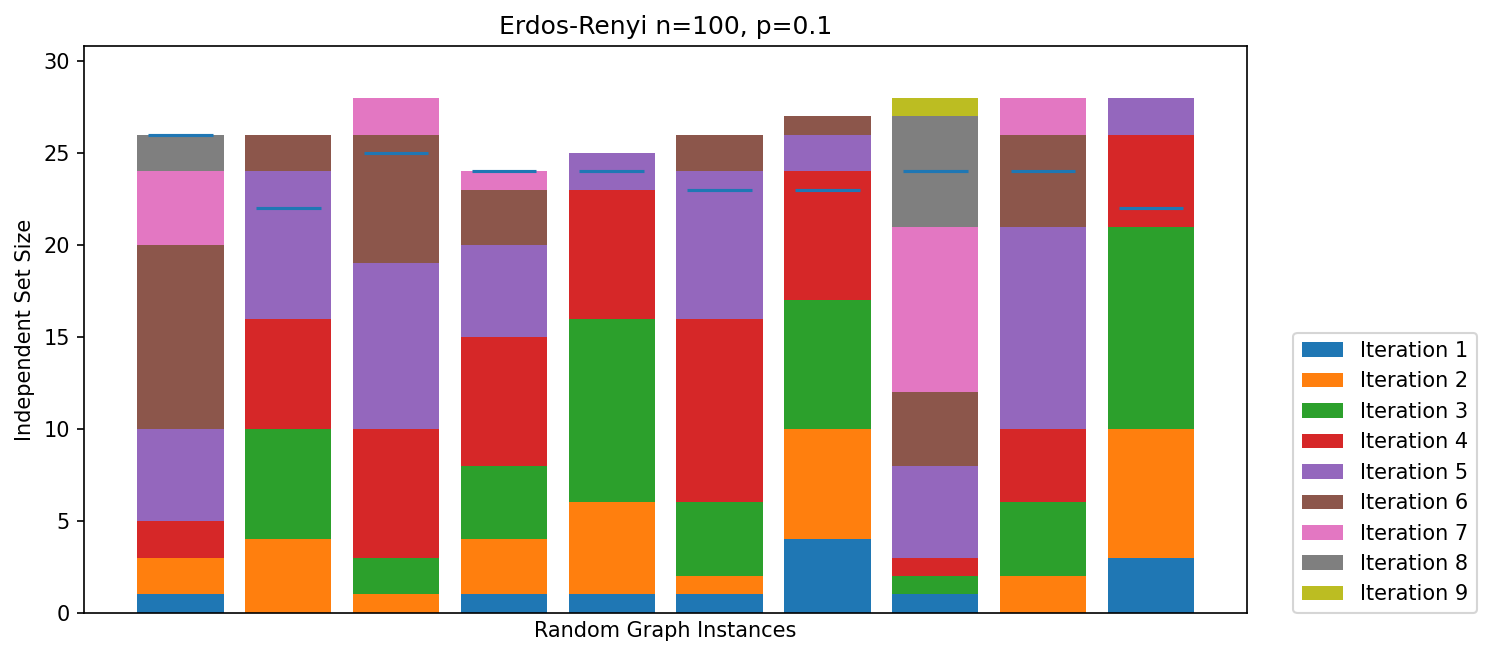

In [20]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 100
p = 0.1

for _ in range(NUM_GRAPHS):
    G = nx.erdos_renyi_graph(n, p)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"Erdos-Renyi n={n}, p={p}"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

START erdos-renyi graphs

Cut 180 edges
Cut 182 edges
Cut 167 edges
Cut 197 edges
Cut 163 edges
Cut 187 edges
Cut 173 edges
Cut 185 edges
Cut 183 edges
Cut 183 edges

START d-regular graphs

Cut 32 edges
Cut 38 edges
Cut 38 edges
Cut 40 edges
Cut 42 edges
Cut 32 edges
Cut 26 edges
Cut 38 edges
Cut 24 edges
Cut 40 edges
(Erdos-Renyi) Average BH is 24.4
(Erdos-Renyi) Average with our classical approach is 25.9
(d-regular) Average BH is 38.2
(d-regular) Average with our classical approach is 38.1


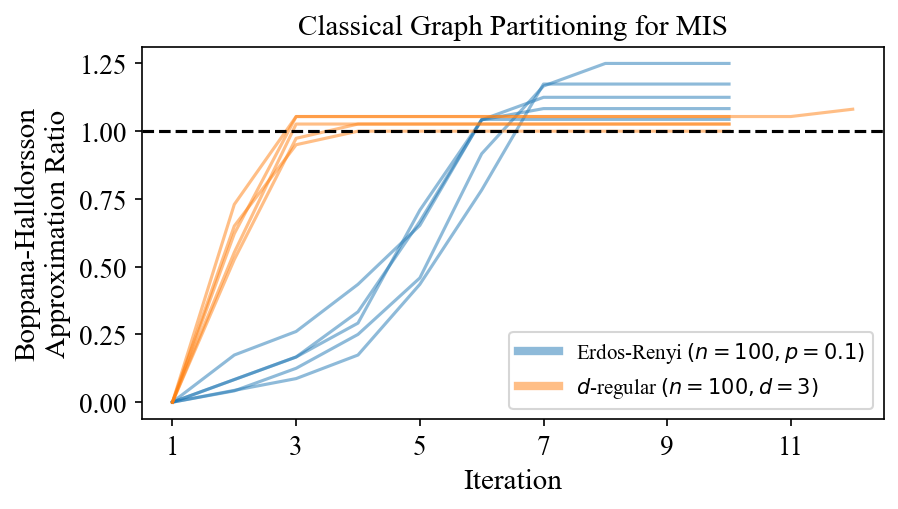

In [35]:
er_bh_list, er_progress_list = [], []
NUM_GRAPHS = 10
n = 100
p = 0.1

print('START erdos-renyi graphs\n')
for _ in range(NUM_GRAPHS):
    G = nx.erdos_renyi_graph(n, p)
    er_bh_list.append(len(approximation.maximum_independent_set(G)))
    er_progress_list.append(classical_MIS_approach(G, verbose=1))

print('\nSTART d-regular graphs\n')
dr_bh_list, dr_progress_list = [], []
d = 3
for _ in range(NUM_GRAPHS):
    G = nx.generators.random_graphs.random_regular_graph(d, n)
    dr_bh_list.append(len(approximation.maximum_independent_set(G)))
    dr_progress_list.append(classical_MIS_approach(G, verbose=1))
    

print("(Erdos-Renyi) Average BH is", np.mean(er_bh_list))
print("(Erdos-Renyi) Average with our classical approach is", np.mean([progress[-1] for progress in er_progress_list]))
print("(d-regular) Average BH is", np.mean(dr_bh_list))
print("(d-regular) Average with our classical approach is", np.mean([progress[-1] for progress in dr_progress_list]))

fig, ax = plt.subplots(dpi=150, figsize=[6,3.5])

er_results = [(run, bh) for run, bh in zip(er_progress_list, er_bh_list)]
dr_results = [(run, bh) for run, bh in zip(dr_progress_list, dr_bh_list)]
er_top_five = sorted(er_results, key=lambda p: p[0][-1] / p[1])[-5:]
dr_top_five = sorted(dr_results, key=lambda p: p[0][-1] / p[1])[-5:]

iterations = []
for i, (run, bh_mis) in enumerate(er_top_five):
    iterations.append(len(run))
    ratio = [val / bh_mis for val in run]
    ax.plot(range(1, len(ratio)+1), ratio, c='tab:blue', ls='-', alpha=0.5)

for (run, bh_mis) in dr_top_five:
    iterations.append(len(run))
    ratio = [val / bh_mis for val in run]
    ax.plot(range(1, len(ratio)+1), ratio, c='tab:orange', ls='-', alpha=0.5)

ax.axhline(y=1, ls='--', c='k')
ax.set_xlim([0.5,max(iterations)+0.5])
ax.set_xticks(np.arange(1,max(iterations),2))
ax.set_xlabel('Iteration', fontsize=14)
ax.set_ylabel('Boppana-Halldorsson\nApproximation Ratio', fontsize=14)
ax.set_title('Classical Graph Partitioning for MIS', fontsize=14)

custom_lines = [Line2D([0], [0], color='tab:blue', lw=4, alpha=0.5),
                Line2D([0], [0], color='tab:orange', lw=4, alpha=0.5)]
ax.legend(custom_lines, [r'Erdos-Renyi $(n=100, p=0.1)$', r'$d$-regular $(n=100, d=3)$'])
plt.tight_layout()
plt.savefig('figures/classical_graph_partitioning.pdf')

In [12]:
er_approx_ratios, dr_approx_ratios = [], []
NUM_GRAPHS = 100
n_range = np.arange(20, 210, 10)
p = 0.1
d = 3

for n in n_range:
    print('-'*30,'\nSTART {}-node graphs'.format(n), '\n' + '-'*30)

    print('\tSTART erdos-renyi graphs')
    temp_approx_ratios = []
    for _ in range(NUM_GRAPHS):
        G = nx.erdos_renyi_graph(n, p)
        bh_mis = len(approximation.maximum_independent_set(G))
        dc_mis = classical_MIS_approach(G)[-1]
        temp_approx_ratios.append(dc_mis / bh_mis)
    er_approx_ratios.append((n, np.mean(temp_approx_ratios), np.std(temp_approx_ratios)))

    print('\tSTART d-regular graphs')
    temp_approx_ratios = []
    for _ in range(NUM_GRAPHS):
        G = nx.generators.random_graphs.random_regular_graph(d, n)
        bh_mis = len(approximation.maximum_independent_set(G))
        dc_mis = classical_MIS_approach(G)[-1]
        temp_approx_ratios.append(dc_mis / bh_mis)
    dr_approx_ratios.append((n, np.mean(temp_approx_ratios), np.std(temp_approx_ratios)))

------------------------------ 
START 20-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 30-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 40-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 50-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 60-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 70-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 80-node graphs 
------------------------------
	START erdos-renyi graphs
	START d-regular graphs
------------------------------ 
START 90-node graphs 
-

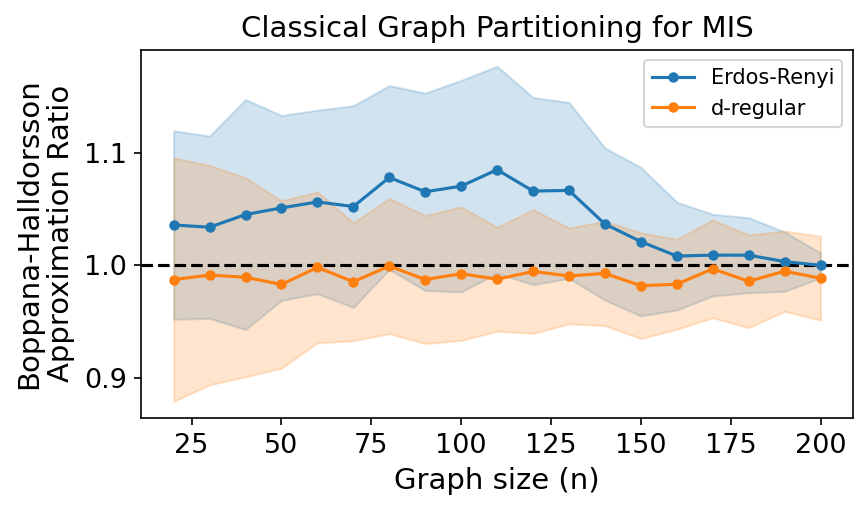

In [15]:
fig, ax = plt.subplots(dpi=150, figsize=[6,3.5])

data = [er_approx_ratios, dr_approx_ratios]
color = ['tab:blue', 'tab:orange']
label = ['Erdos-Renyi', 'd-regular']
for i, dat in enumerate(data):
    x = [d[0] for d in dat]
    means = [d[1] for d in dat]
    stddevs = [d[2] for d in dat]
    
    ax.errorbar(x, means, label=label[i], fmt='-o', ms=4, color=color[i])

    y1 = [m+s for m, s in zip(means, stddevs)]
    y2 = [m-s for m, s in zip(means, stddevs)]
    ax.fill_between(x, y1, y2, alpha=0.2, color=color[i])


ax.axhline(y=1, ls='--', c='k')
#ax.set_xlim([0.5,max(iterations)+0.5])
#ax.set_xticks(np.arange(1,max(iterations),2))
ax.set_xlabel('Graph size (n)', fontsize=14)
ax.set_ylabel('Boppana-Halldorsson\nApproximation Ratio', fontsize=14)
ax.set_title('Classical Graph Partitioning for MIS', fontsize=14)

#custom_lines = [Line2D([0], [0], color='tab:blue', lw=4, alpha=0.5),
#                Line2D([0], [0], color='tab:orange', lw=4, alpha=0.5)]
ax.legend()
plt.tight_layout()
plt.savefig('figures/classical_scaling.pdf')

In [19]:
er_degrees = []
for n in n_range:
    temp_degree = []
    for _ in range(NUM_GRAPHS):
        G = nx.erdos_renyi_graph(n, p)
        degs = [d[1] for d in G.degree]
        temp_degree.append(np.mean(degs))
    er_degrees.append((n, np.mean(temp_degree), np.std(temp_degree)))
    
dr_degrees = []
for n in n_range:
    temp_degree = []
    for _ in range(NUM_GRAPHS):
        G = nx.generators.random_graphs.random_regular_graph(d, n)
        degs = [d[1] for d in G.degree]
        temp_degree.append(np.mean(degs))
    dr_degrees.append((n, np.mean(temp_degree), np.std(temp_degree)))

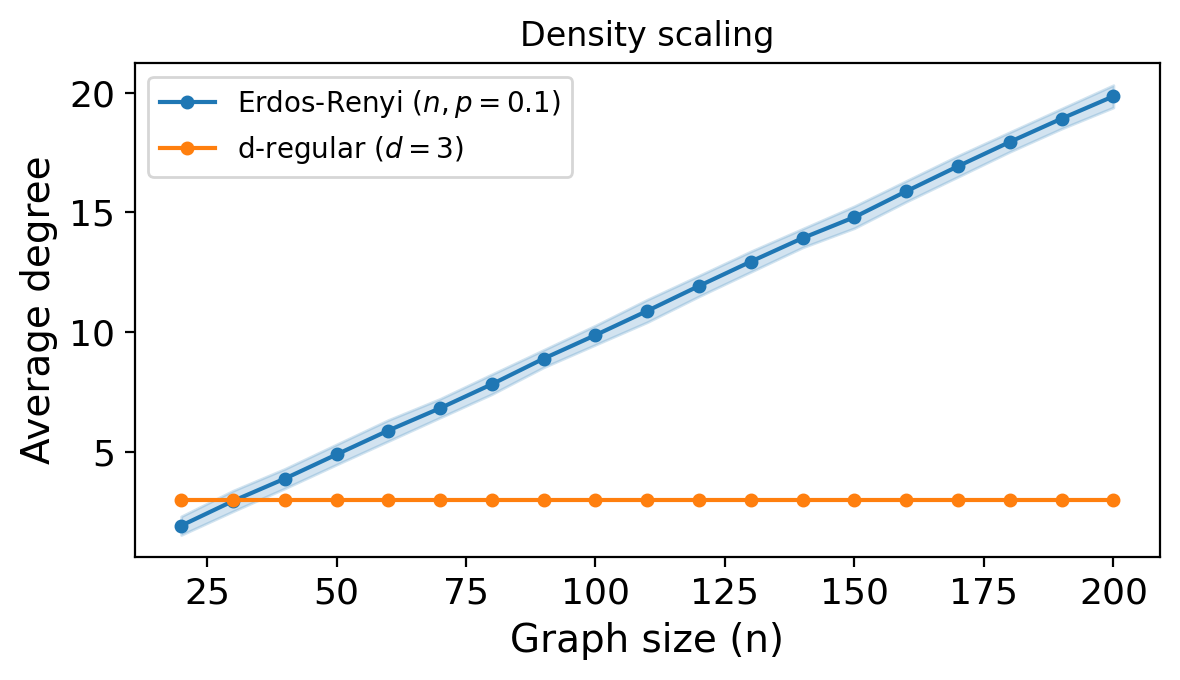

In [25]:
fig, ax = plt.subplots(dpi=200, figsize=[6,3.5])



data = [er_degrees, dr_degrees]
color = ['tab:blue', 'tab:orange']
label = [r'Erdos-Renyi $(n, p=0.1)$', r'd-regular $(d=3)$']
for i, dat in enumerate(data):
    x = [d[0] for d in dat]
    y = [d[1] for d in dat]
    std = [d[2] for d in dat]
    
    ax.errorbar(x, y, label=label[i], fmt='-o', ms=4, color=color[i])

    y1 = [m+s for m, s in zip(y, std)]
    y2 = [m-s for m, s in zip(y, std)]
    ax.fill_between(x, y1, y2, alpha=0.2, color=color[i])

ax.set_ylabel('Average degree', fontsize=14)
ax.set_xlabel('Graph size (n)', fontsize=14)
ax.set_title('Density scaling')
ax.legend()
plt.tight_layout()
plt.savefig('figures/density_scaling.pdf')

Average BH is 62.1
Average with our classical approach is 60.8


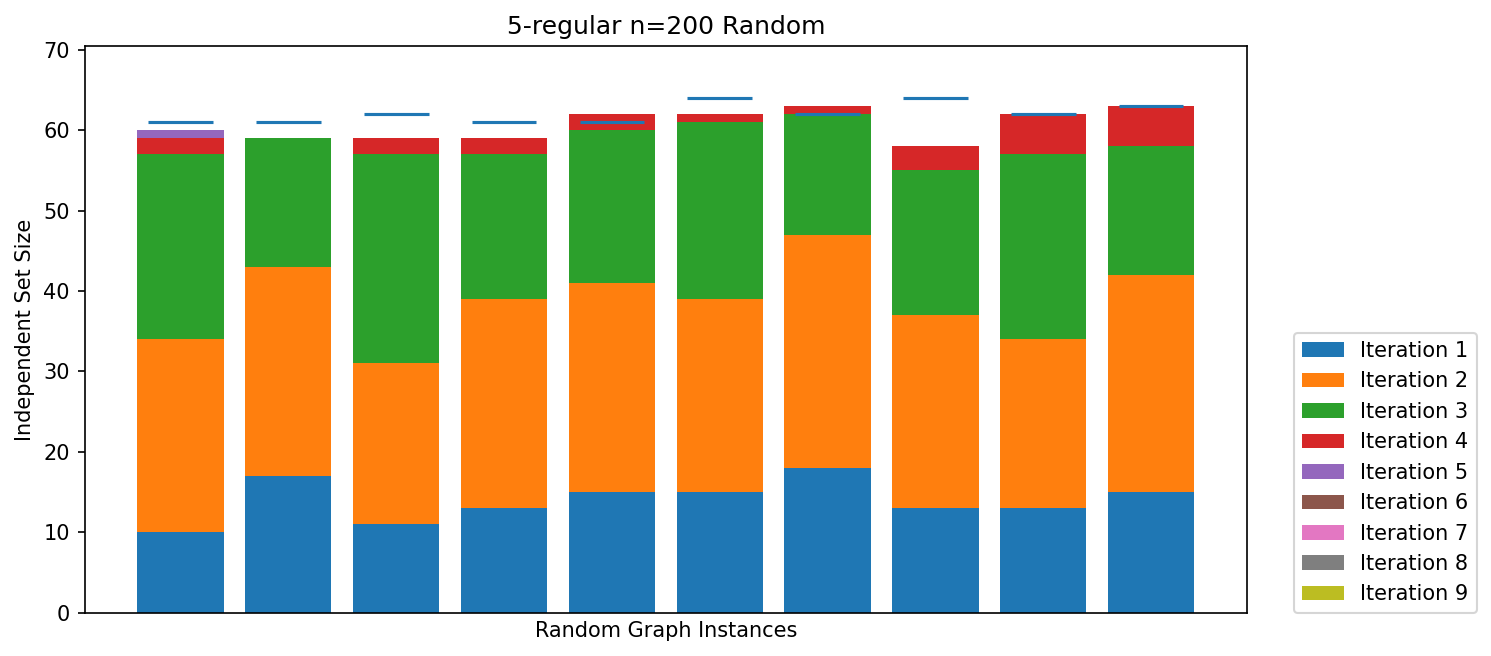

In [22]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 200
d = 5

for _ in range(NUM_GRAPHS):
    G = nx.random_regular_graph(d, n)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"{d}-regular n={n} Random"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

Average BH is 122.2
Average with our classical approach is 125.2


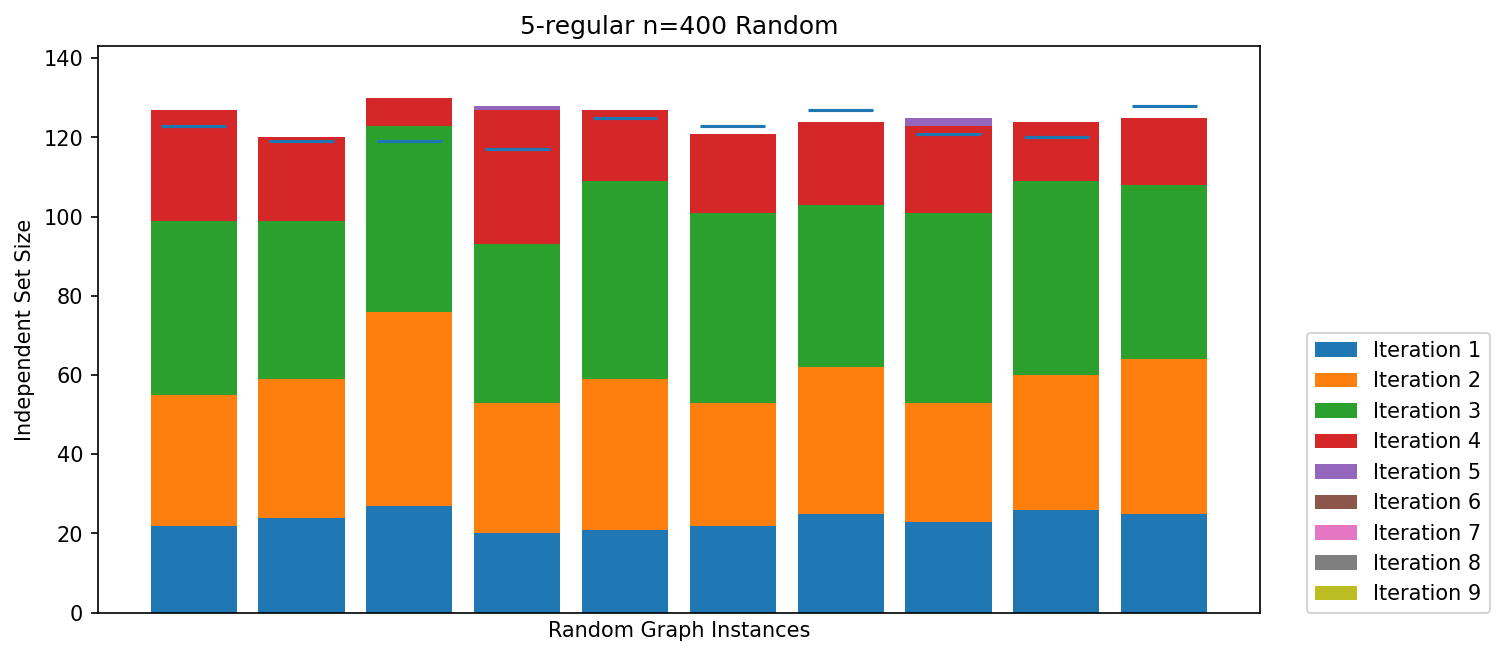

In [23]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 400
d = 5

for _ in range(NUM_GRAPHS):
    G = nx.random_regular_graph(d, n)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"{d}-regular n={n} Random"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

Average BH is 75.6
Average with our classical approach is 76.2


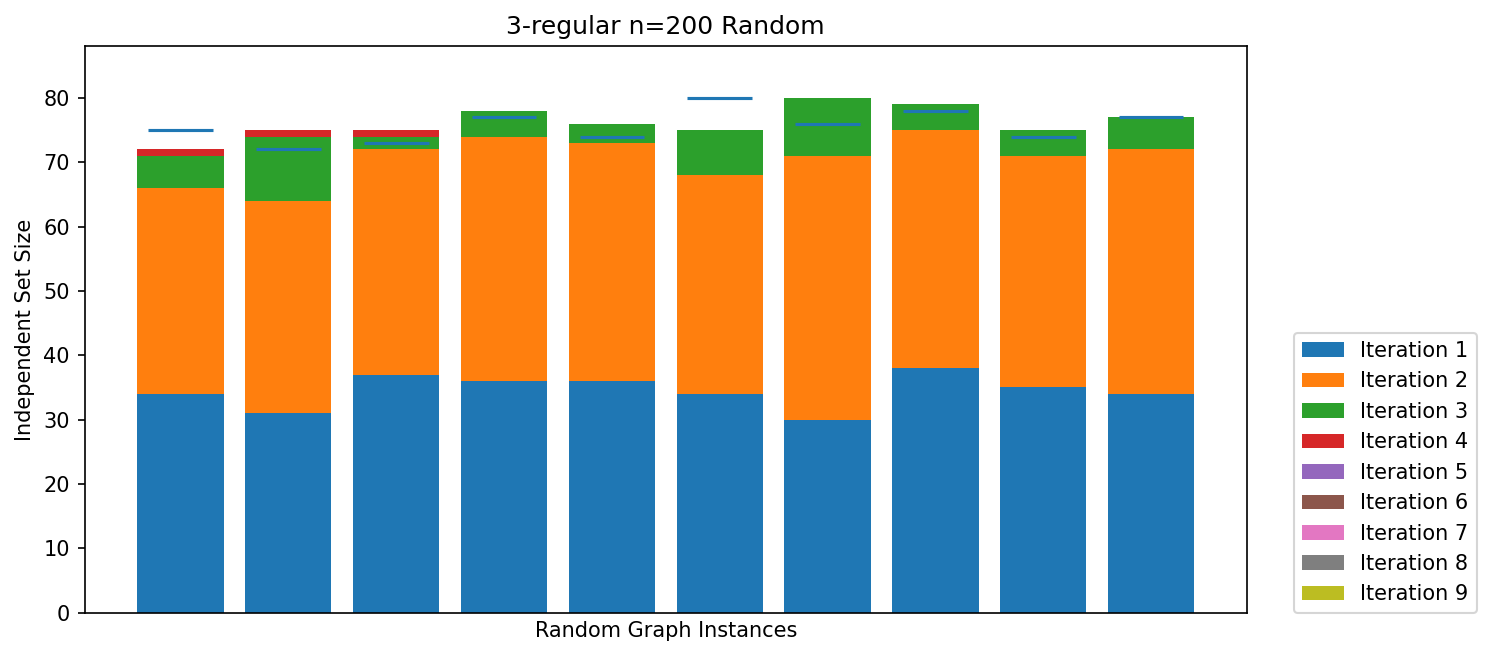

In [24]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 200
d = 3

for _ in range(NUM_GRAPHS):
    G = nx.random_regular_graph(d, n)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"{d}-regular n={n} Random"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

Average BH is 152.1
Average with our classical approach is 152.4


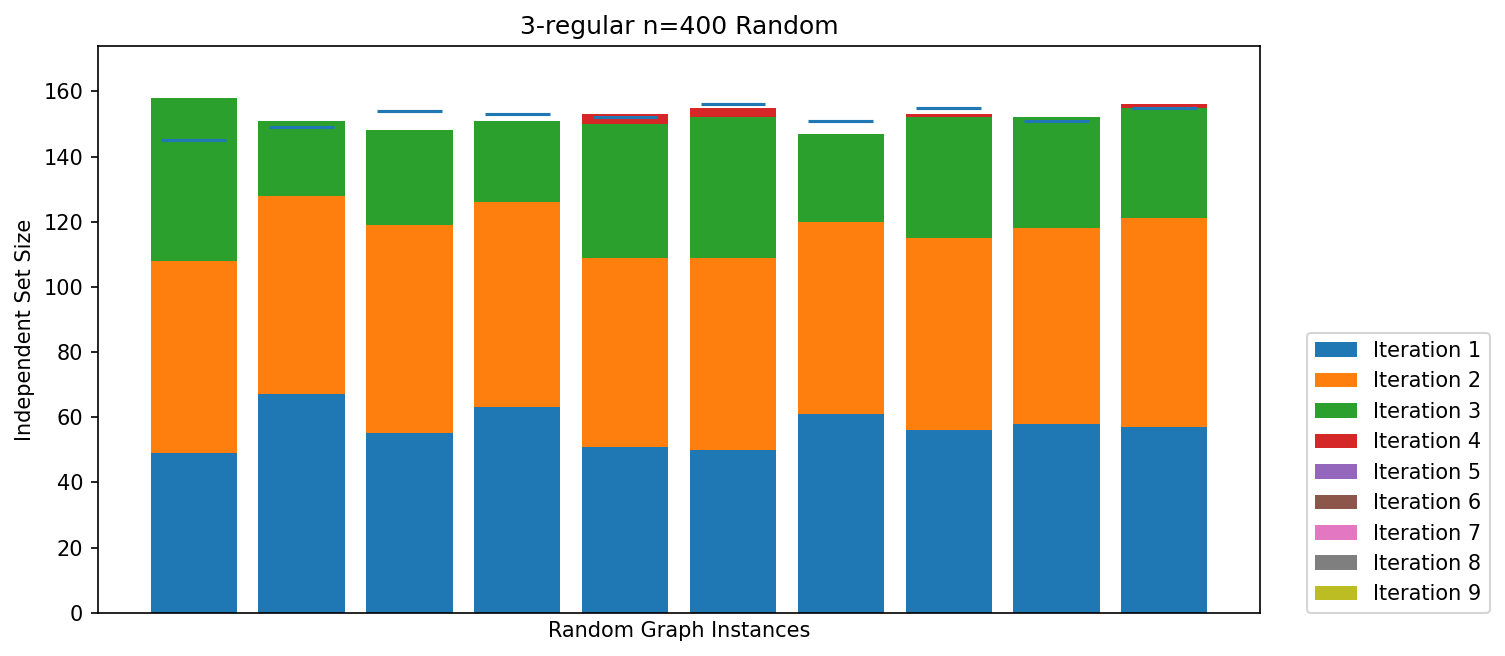

In [25]:
bh_list, progress_list = [], []
NUM_GRAPHS = 10
n = 400
d = 3

for _ in range(NUM_GRAPHS):
    G = nx.random_regular_graph(d, n)
    bh_list.append(len(approximation.maximum_independent_set(G)))
    progress_list.append(classical_MIS_approach(G))
    
    
plt.figure(dpi=150, figsize=(10, 5))
plt.title(f"{d}-regular n={n} Random"); plt.xlabel("Random Graph Instances"); plt.ylabel("Independent Set Size")
plt.ylim(
    0,
    max([max([max(progress) for progress in progress_list]), max(bh_list)]) * 1.1
)
plt.xticks([])

    
for j in range(1, MAX_RECURSION_DEPTH):
    plt.bar(
        range(NUM_GRAPHS),
        [progress[j] - progress[j - 1] for progress in progress_list],
        bottom=[progress[j - 1] for progress in progress_list],
        label=f"Iteration {j}",
    )
    
for i in range(NUM_GRAPHS):
    plt.hlines(bh_list[i], xmin=i-0.3, xmax=i+0.3)
    
plt.legend(loc=(1.04,0));

print("Average BH is", np.mean(bh_list))
print("Average with our classical approach is", np.mean([progress[-1] for progress in progress_list]))

# Collect Classical Data
Run the classical divide and conquer algorithm and the boppana-halldorsson algorithm on the 26-node test graphs

In [39]:
from utils.graph_funcs import graph_from_file
import glob

In [49]:
graphs = glob.glob('benchmark_graphs/N26_d3_graphs/*')
for graphfn in graphs:
    print('/'.join(graphfn.split('/')[1:]))
    graphname = graphfn.split('/')[-1].strip('.txt')
    G = graph_from_file(graphfn)
    for rep in range(1,6):
        print('\tREP', rep)
        bh_mis = len(approximation.maximum_independent_set(G))
        with open('benchmark_results/boppana-halldorsson/{}/bh_{}_rep{}.txt'.format(
                  graphname, graphname, rep), 'w') as fn:
            fn.write(graphfn + '\n')
            fn.write('Found MIS of size: {}'.format(bh_mis))
        
        dc_mis = classical_MIS_approach(G)
        with open('benchmark_results/classical_divide_and_conquer/{}/dc_{}_rep{}.txt'.format(
              graphname, graphname, rep), 'w') as fn:
            fn.write(graphfn + '\n')
            fn.write('Found MIS of size: {}'.format(dc_mis))

N26_d3_graphs/G2.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G3.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G1.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G4.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G5.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G7.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G6.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G14.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G15.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G11.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G10.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G12.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G13.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G8.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
N26_d3_graphs/G9.txt
	REP 1
	REP 2
	REP 3
	REP 4
	REP 5
